# Mass Spectrometry Group Alignment of Mouse Pancreate Data

Dataset can be downloaded from https://zenodo.org/record/3607915#.Y_To9nbMJrr and paper from doi: https://doi.org/10.1016/j.molmet.2020.01.017.

## Preparation

Loading Packages

In [1]:
import os,csv,random
import pandas as pd
import numpy as np
import scanpy as sc
import math

from skimage import io, color
import torch


In [2]:
from scanpy import read_10x_h5
import SpaGCN as spg
import matplotlib.pyplot as plt
import json

In [3]:
from tqdm import tqdm
import pickle

In [4]:
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.metadata import Metadata

In [5]:
%cd /lustre03/project/6075067/calcium/2021/MALDI

/lustre03/project/6075067/calcium/2021/MALDI


In [6]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/MALDI/MALDI_package')

import MALDIpython as MALDIpy
MALDIpy.__version__

'1.0.0'

## Data Loading

We first take the DS26 (the normal tissue) as the reference 

In [12]:
Ref_file = '/lustre03/project/6075067/calcium/2021/MALDI/data/MousePancreate/mouse_islet_of_langerhans_preliminary_peaks.imzML'
p = ImzMLParser(Ref_file)
spectra_mz = []
spectra_intensity = []
x_cord = []
y_cord = []
z_cord = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    spectra_mz.append(mzs)
    spectra_intensity.append(intensities)
    x_cord.append(x)
    y_cord.append(y)
    z_cord.append(z)

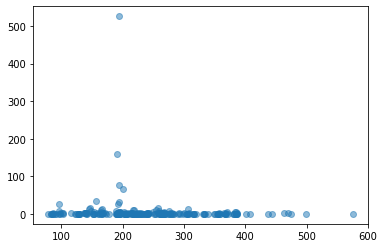

In [13]:
plt.scatter(mzs, intensities, alpha=0.5)
plt.show()

In [14]:
len(spectra_mz)

51112

## Data Preprocessing
skip this step if .h5ad is already generated.
#### Gaussian Kernal Weighted Average by Nadaraya–Watson estimator

Due to the difference between to  m/z values of two adjacent observation is not evenly, we employed Gaussian Kernal to grid the processed m/z values into grid. i.e., the values are evenly distributed. 

In [10]:
RESULTS = MALDIpy.gridding(mzs, intensities)
RESULTS

/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/util.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(Weighted)  / np.sum(Kernal)


[array([ 77.   ,  77.125,  77.25 , ..., 576.625, 576.75 , 576.875]),
 array([0., 0., 0., ..., 0., 0., 0.])]

Zero percentage:

In [11]:
np.count_nonzero(RESULTS[1])/RESULTS[1].shape[0]

0.44125

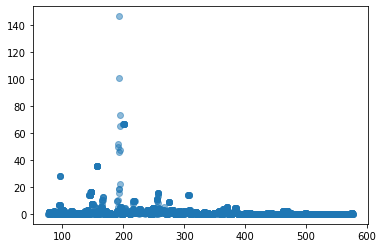

In [12]:
plt.scatter(RESULTS[0], RESULTS[1], alpha=0.5)
plt.show()

#### Grid all m/z values to the same reference grid.

In [ ]:
STARTmz = 70
ENDmz = 600

spectra_gridded = []
for idx in tqdm(range(len(spectra_mz))):
    RESULTS = MALDIpy.gridding(spectra_mz[idx], spectra_intensity[idx], start = STARTmz, end = ENDmz, increment = 0.25)
    spectra_gridded.append(RESULTS[1])
    
    

In [ ]:
mzs_new = RESULTS[0]

In [ ]:
mz_value = pd.DataFrame(mzs_new, index = mzs_new.astype('float'))
mz_value = mz_value.rename(columns = {0:"m/z"})

In [ ]:
MALDIloc = pd.DataFrame({'x':x_cord, 'y':y_cord, 'z':z_cord})

In [ ]:
MALDIspectrum = np.stack(spectra_gridded)    
MALDIdataAnn = sc.AnnData(X = MALDIspectrum, var = mz_value, obs = MALDIloc)

In [17]:
MALDIdataAnn.write_h5ad(filename = "/lustre03/project/6075067/calcium/2021/MALDI/data/MousePancreate/MousePancreate_small.h5ad")

## Simulation

Load the Annotated data directly

In [15]:
MALDIdataAnn = sc.read_h5ad (filename  = "/lustre03/project/6075067/calcium/2021/MALDI/data/MousePancreate/MousePancreate_small.h5ad")

In [16]:
MALDIdataAnn.obs = MALDIdataAnn.obs.astype(int)
sc.pp.normalize_per_cell(MALDIdataAnn)

### 0. Preparation: peaks calling and peaks grouping

In [17]:
PeakGroup = MALDIpy.PeakCalling_single (MALDIdataAnn)
PeakGroup.callpeak(0.9)
PeakGroup.grouppeaks(0.95)

We first create an MALDIdataAnn object of the exact alignment of two Mass Spectrometry data. Since it is expected to be an exact alignment, we consider the unknown and reference data are from the same dataset.

In [18]:
ExactAlign = MALDIpy.AnnDataMALDI(MALDIdataAnn, MALDIdataAnn)
ExactAlign.get_corr_peakgroup_refined(PeakGroup.jointcluster)
ExactAlign.greedy_match()
ExactAlign.fine_align(threshould = 0.8, ignore = True)
ExactAlign.summarize()

 64%|██████▎   | 14/22 [00:00<00:00, 25.95it/s]/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Core/scipy-stack/2022a/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 21/21 [00:00<00:00, 1170.29it/s]


The results show that no shifting adjustment need to be done as the shift lengths for all groups are 0. 

In [19]:
ExactAlign.changerecord

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Define the function of conducting simulations studies.

In [18]:
def SIM ( change_trace_first12, sigma, filename):
    ExactAlign.changerecord[0:12] = change_trace_first12
    SD = MALDIpy.MALDI_SIM(ExactAlign)
    MALDISimData = SD.getAnnSim(shuffle = True, sigma = 0.1, nregion = 1)
    # Stage 1: Peak grouping ...
    Stage1 = MALDIpy.PeakCalling (MALDISimData, MALDIdataAnn)
    Stage1.callpeak(0.9)
    Stage1.grouppeaks(0.95)
    # Stage 2: Alignment ...
    Stage2 = MALDIpy.AnnDataMALDI(MALDISimData, MALDIdataAnn)
    Stage2.get_corr_peakgroup_refined(Stage1.jointcluster)
    Stage2.greedy_match()
    Stage2.fine_align(threshould = 0.2, ignore = True)
    Stage2.summarize()
    # Simulation Done. The results:
    results = SD.MSE(Stage2.unknownalign, Stage2.referenalign)
    # MALDISimData.write(filename = filename)
    return results[0].mean()

In [21]:
MALDIdataAnn.write(filename = "/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/simdata/SimData_Ref.h5ad")

## MS-GAlign

### 1. Scenario 1: small changes (sigma = 0.2)

In [17]:
random.seed(2023)
MSE = []

for i in range(500):
    try:
        results = SIM ([1,0,2,0,1,0,0,0,0,0,0,0], sigma = 0.2, filename = "/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/simdata/SimData_{index}.h5ad".format(index = i))
        MSE.append(results)
    except:
        MSE.append(float('nan'))
    
   

100%|██████████| 21/21 [00:01<00:00, 14.90it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 21/21 [00:01<00:00, 14.96it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X,

In [18]:
np.savetxt('/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/small_changes_sigma01.txt', np.array(MSE), delimiter=',')

In [19]:
np.array(MSE)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
SD = MALDIpy.MALDI_SIM(ExactAlign)
MALDISimData = SD.getAnnSim(shuffle = True, sigma = 0.1, nregion = 1)

100%|██████████| 21/21 [00:03<00:00,  6.88it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
SD.shiftdatadf

,mzvalue_start,mzvalue_end,shift_fromorigin,shift_fromprev,currentshift_fromprev,currentshift_fromorg
0,79.250,109.500,1.0,1.0,1.0,1.0
1,114.000,121.500,0.0,-1.0,-1.0,0.0
2,126.375,131.875,2.0,2.0,2.0,2.0
3,138.750,172.000,0.0,-2.0,-2.0,0.0
4,178.000,202.000,1.0,1.0,1.0,1.0
5,205.875,235.875,0.0,-1.0,-1.0,0.0
6,239.625,245.000,0.0,0.0,0.0,0.0
7,250.750,263.750,0.0,0.0,0.0,0.0
8,267.875,309.125,0.0,0.0,0.0,0.0
9,314.000,335.875,0.0,0.0,0.0,0.0


Stage 1: Peak grouping ...

In [30]:
Stage1 = MALDIpy.PeakCalling (MALDISimData, MALDIdataAnn)
Stage1.callpeak(0.9)
Stage1.grouppeaks(0.95)

Stage 2: Alignment ...

In [31]:
Stage2 = MALDIpy.AnnDataMALDI(MALDISimData, MALDIdataAnn)

In [32]:
Stage2.meanspectrumUnk[110:140]

array([ 1.55214  ,  1.5527468,  1.5519445,  2.1374762,  2.4622939,
        2.5170665,  2.576808 ,  2.2897258,  4.070794 ,  4.3097477,
       24.561644 ,  5.9083605,  2.9744198,  3.0739763, 14.490391 ,
       43.98899  , 52.62913  , 27.5491   , 27.437536 , 16.36263  ,
       30.853344 , 30.768826 ,  5.527765 ,  5.3062997,  2.356995 ,
        7.1501136,  7.2539425,  7.254092 ,  7.0923653,  7.0796175],
      dtype=float32)

In [33]:
Stage2.meanspectrumRef[110:140]

array([ 0.5475715,  0.5476266,  1.1323944,  1.4571693,  1.5118289,
        1.5721526,  1.2847732,  3.066237 ,  3.3046985, 23.556627 ,
        4.9026413,  1.968927 ,  2.0694208, 13.485783 , 42.984406 ,
       51.623875 , 26.54436  , 26.432575 , 15.358093 , 29.848804 ,
       29.764166 ,  4.523916 ,  4.3016515,  1.351471 ,  6.144993 ,
        6.249554 ,  6.2494764,  6.0871243,  6.0751214,  1.1635715],
      dtype=float32)

In [21]:
Stage2 = MALDIpy.AnnDataMALDI(MALDISimData, MALDIdataAnn)
Stage2.get_corr_peakgroup_refined(Stage1.jointcluster)
Stage2.greedy_match()
Stage2.fine_align(threshould = 0.2, ignore = True)
Stage2.summarize()

100%|██████████| 41/41 [00:00<00:00, 763.98it/s]


Simulation Done. The results:

In [22]:
results = SD.MSE(Stage2.unknownalign, Stage2.referenalign)

Output the results:

In [25]:
results[0].sum()

0.0

### 2. Scenario 2: large changes (sigma = 0.5)

In [20]:
def SIM_large ( change_trace_first12, sigma, filename):
    ExactAlign.changerecord = change_trace_first12
    SD = MALDIpy.MALDI_SIM(ExactAlign)
    MALDISimData = SD.getAnnSim(shuffle = True, sigma = 0.1, nregion = 2)
    # Stage 1: Peak grouping ...
    Stage1 = MALDIpy.PeakCalling (MALDISimData, MALDIdataAnn)
    Stage1.callpeak(0.9)
    Stage1.grouppeaks(0.95)
    # Stage 2: Alignment ...
    Stage2 = MALDIpy.AnnDataMALDI(MALDISimData, MALDIdataAnn)
    Stage2.get_corr_peakgroup_refined(Stage1.jointcluster)
    Stage2.greedy_match()
    Stage2.fine_align(threshould = 0.2, ignore = True)
    Stage2.summarize()
    # Simulation Done. The results:
    results = SD.MSE(Stage2.unknownalign, Stage2.referenalign)
    # MALDISimData.write(filename = filename)
    return results[0].mean()

In [ ]:
random.seed(2023)
MSE = []

for i in range(500):
    try:
        results = SIM_large ([1,2,1,0,1,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0,3,0,2,0,1], sigma = 0.5, filename = "/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/simdata/SimData_large_{index}.h5ad".format(index = i))
        MSE.append(results)
    except:
        MSE.append(float('nan'))

100%|██████████| 21/21 [00:02<00:00,  7.12it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 21/21 [00:02<00:00,  7.19it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X,

In [ ]:
np.savetxt('/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/large_changes_sigma05.txt', np.array(MSE), delimiter=',')

In [ ]:
MSE

In [10]:
data = pd.read_csv("/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/large_changes_sigma05.txt", header = None)
data.mean()

0    0.067711
dtype: float64

In [ ]:
### 2. Scenario 3: large changes (sigma = 1)

In [19]:
random.seed(2023)
MSE = []

for i in range(500):
    try:
        results = SIM ([1,2,1,0,1,3,0,2,0,2,1,0], sigma = 1, filename = "/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/simdata/SimData_large_{index}.h5ad".format(index = i))
        MSE.append(results)
    except:
        MSE.append(float('nan'))

100%|██████████| 21/21 [00:03<00:00,  6.35it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 21/21 [00:03<00:00,  6.53it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X,

In [ ]:
np.savetxt('/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/large_changes_sigma01.txt', np.array(MSE), delimiter=',')

In [21]:
MSE

[0.05586870026525199,
 0.0,
 0.03684826203208556,
 0.0,
 0.0,
 0.30827328159645234,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0009353741496598639,
 0.0,
 0.0,
 0.005551816958277255,
 0.0,
 0.0,
 0.0,
 0.5907039711191335,
 0.0008480325644504749,
 0.0,
 0.0,
 0.0,
 0.015042372881355933,
 0.0,
 0.0056352459016393444,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6133603238866396,
 0.0,
 0.0,
 0.022393048128342245,
 0.0,
 0.0,
 0.003540843214756258,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2711588541666667,
 0.0,
 0.0,
 0.0,
 0.0,
 0.016225261932479626,
 0.0,
 0.003714470284237726,
 0.0,
 0.006341789052069426,
 0.3188139386189258,
 0.0,
 0.0,
 0.33373397435897434,
 0.0,
 0.0,
 0.018211920529801324,
 0.0,
 0.0,
 0.0,
 0.11318242343541944,
 0.0,
 0.0,
 0.0,
 0.32087126137841354,
 0.0,
 0.01751644736842105,
 0.33125841184387617,
 0.0,
 0.0,
 0.0,
 0.0,
 0.014290407358738502,
 0.0062997347480106105,
 0.008070054945054946,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.21555059523809525,
 0.0,
 0.0008716875871687587,
 0.44080

In [11]:
data = pd.read_csv("/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/large_changes_sigma01.txt", header = None)
data.mean()

0    0.067363
dtype: float64

## Competing method: MSIwarp

In [18]:
import msiwarp as mx
from msiwarp.util.warp import to_mx_peaks
from msiwarp.util.warp import to_mz, to_height


In [19]:
def MSIwarping (MALDIdataAnn1, MALDIdataAnn2):
    spectra = []
    mzs = np.array(MALDIdataAnn1.var["m/z"]).astype(np.float) # peak m/z values
    meanspectrum1 =  np.mean(MALDIdataAnn1.X, axis = 0)
    for i in range(0,MALDIdataAnn1.X.shape[0],100):
        hs = meanspectrum1
        spectra.append( [mx.peak(i, mz_i, h_i, 1.0) for i, (mz_i, h_i) in enumerate(zip(mzs, hs))])
    #
    hs = meanspectrum1 # peak heights
    s = [mx.peak(i, mz_i, h_i, 1.0) for i, (mz_i, h_i) in enumerate(zip(mzs, hs))]
    #
    mzs2 = np.array(MALDIdataAnn2.var["m/z"]).astype(np.float) # peak m/z values
    meanspectrum2 =  np.mean(MALDIdataAnn2.X, axis = 0)
    hs2 = meanspectrum2 # peak heights
    s2 = [mx.peak(i, mz_i, h_i, 1.0) for i, (mz_i, h_i) in enumerate(zip(mzs2, hs2))]
    #
    reference_spectrum =  s2
    ### 1.2 setup the node placement parameters ######
    # method 1
    node_mzs = [i for i in range(15,1200,50)]
    node_deltas = [i*0.01 for i in range(15,121,5)] # slacks = node_deltas * n_steps
    n_steps = 30
    nodes = mx.initialize_nodes(node_mzs, node_deltas, n_steps)
    epsilon = 1 # peak matching threshold, relative to peak width
    #
    optimal_moves = mx.find_optimal_spectra_warpings(spectra, reference_spectrum, nodes, epsilon)
    spectra2 = [[mx.peak(i, mz_i, h_i, 1.0) for i, (mz_i, h_i) in enumerate(zip(mzs.astype(np.float), mzs))]]
    #
    warped_spectra = [mx.warp_peaks(s_i, nodes, optimal_moves[0]) for s_i in spectra2]
    #
    newmz = to_mz(warped_spectra[0])
    oldmz = to_height(warped_spectra[0])
    return {"newmz":newmz, "oldmz":oldmz}

In [25]:
len(orgmzidx)

2120

In [ ]:
## MSE result plot
resultsdf = pd.DataFrame({"MSE":MSE, "unkmz":SD.truemz[orgmzidx], "refmz": warpresult.get("newmz")})
resultsdf.to_csv("output/simulation/MSE_results_1simulation_wapring.csv", sep = ",")

In [36]:
def SIM_msiwarp (change_trace_first12, sigma):
    ExactAlign.changerecord[0:12] = change_trace_first12
    SD = MALDIpy.MALDI_SIM(ExactAlign)
    MALDISimData = SD.getAnnSim(shuffle = True, sigma = 0.1, nregion = 1)
    # Warping ...
    warpresult = MSIwarping (MALDISimData, MALDIdataAnn_REf)
    orgmz = warpresult.get("oldmz")
    orgmzidx = [np.where(abs(np.array(MALDISimData.var["m/z"])-orgmzi)==abs(np.array(MALDISimData.var["m/z"])-orgmzi).min())[0].max() for orgmzi in orgmz]
    # Simulation Done. The results:
    results = np.mean(np.square(SD.truemz[orgmzidx] - warpresult.get("newmz")))
    return results

In [42]:
results = SIM_msiwarp ([1,0,2,0,1,0,0,0,0,0,0,0], sigma = 0.2)
results

100%|██████████| 21/21 [00:01<00:00, 14.36it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
<ipython-input-19-d7ee5cefa3e2>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more det

0.10948786764884572

### 1. Scenario 1: small changes (sigma = 0.2)

In [ ]:
random.seed(2023)
MSE = []

for i in range(500):
    try:
        results = SIM_msiwarp ([1,0,2,0,1,0,0,0,0,0,0,0], sigma = 0.2)
        MSE.append(results)
    except:
        MSE.append(float('nan'))


100%|██████████| 21/21 [00:01<00:00, 14.34it/s]
/lustre03/project/6075067/calcium/2021/MALDI/MALDIpython/AnnDataMALDI.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  MALDISimData = sc.AnnData(X = self.newarray, var = mz_value, obs = self.origindata.obs)
/home/calcium/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
<ipython-input-19-d7ee5cefa3e2>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more det

In [ ]:
np.savetxt('/lustre03/project/6075067/calcium/2021/MALDI/output/simulation/small_changes_sigma02_MSIwarp.txt', np.array(MSE), delimiter=',')

In [ ]:
### 1. Scenario 2: Large changes (sigma = 0.2)